In [1]:
'''
数据准备脚本
1. 汇总下列数据到一起：
- example
- greedy generation
- greedy hidden states
- high-t generations
- cluster_ids
2. 计算语义熵

最终格式like:
{
	"example": {
		"id": "id1",
		"question": "q1",
		"context": "c1",
		"answers": ["a1"]
	},
	"golden": {
		"greedy": {
			"text": "",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
            "accuracy": 1.0,
		},
		"sample": ["r1","r2"],
		"cluster_ids": [0,1],
        "accuracy": [1.0, 0.0],
		"entropy": 1.5
	},
	"irrelevant": {
		"greedy": {
			"text": "",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
            "accuracy": 1.0,
		},
		"sample": ["r1","r2"],
		"cluster_ids": [0,1],
        "accuracy": [1.0, 0.0],
		"entropy": 1.5
	},
	"without": {
		"greedy": {
			"text": "",
			"tbg_emb": Tensor(),
			"slt_emb": Tensor(),
            "accuracy": 1.0,
		},
		"sample": ["r1","r2"],
		"cluster_ids": [0,1],
        "accuracy": [1.0, 0.0],
		"entropy": 1.5
	},
}
'''

import os
import pickle
from tqdm import tqdm
from collections import defaultdict
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
from core.computation.uncertainty_measure import cluster_assignment_entropy

def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    # 如果file_path的目录不存在，则创建
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_text_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            if 'error' in r:
                continue
            responses.append(r['text'])
    return responses

def load_responses(generation_file_path):
    responses = []
    if os.path.exists(generation_file_path):
        res = load_pickle_file(generation_file_path)
        for r in res['responses']:
            if 'error' in r:
                continue
            it = {}
            it['text'] = r['text']
            it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            # if 'text' in r:
            #     it['text'] = r['text']
            # if 'hidden_states' in r:
            #     it['slt_emb'] = r['hidden_states']['sec_last_token_embedding']
            #     it['tbg_emb'] = r['hidden_states']['last_tok_bef_gen_embedding']
            responses.append(it)
    return responses

def load_greedy_response(generation_file_path):
    responses = load_responses(generation_file_path)
    assert len(responses) <= 1, f"More than one response found in {generation_file_path}."
    return responses[0] if responses else None

def load_cluster_ids(clustered_file_path):
    cluster_ids = []
    if os.path.exists(clustered_file_path):
        res = load_pickle_file(clustered_file_path)
        cluster_ids = res.get('cluster_ids', [])
    return cluster_ids

def load_accuracy(eval_file_path):
    accuracy = []
    if os.path.exists(eval_file_path):
        res = load_pickle_file(eval_file_path)
        accuracy = res.get('qwen_scores', [])
    return accuracy

def load_greedy_accuracy(eval_file_path):
    accuracy = load_accuracy(eval_file_path)
    assert len(accuracy) <= 1, f"More than one accuracy found in {eval_file_path}."
    return accuracy[0] if accuracy else None

def get_dataset_json_filename(dataset_name, split, size='small'):
    assert size in ['small', 'large'], f"Invalid size {size}."
    size_map = {
        'small': {
            'train': 2000,
            'validation': 100,
            'test': 100,
        },
        'large': {
            'train': 10000,
            'validation': 1000,
            'test': 1000,
        }
    }
    num_samples = size_map[size][split]
    return f"{dataset_name}_{split}_{num_samples}.json"

# 计算准确率
def compute_accuracy(scores):
    if len(scores) == 0:
        return -1
    return sum(1 for score in scores if score >= 0.5) / len(scores)

# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return -1
    return cluster_assignment_entropy(cluster_ids)

def prepare_data(dataset_name, split, model_name):
    model_short_name = model_name.split("/")[0]
    # 加载数据集
    dataset_json_file = f"output/dataset/{get_dataset_json_filename(dataset_name, split)}"
    assert os.path.exists(dataset_json_file), f"Dataset json file {dataset_json_file} not found."
    id_list, data_dict = load_ds_from_json(dataset_json_file)

    result = {
        'id': id_list,
        'data': defaultdict(dict),
    }
    for i, example_id in enumerate(tqdm(id_list, desc=f"Preparing {dataset_name} {split} {model_short_name}")):
        assert example_id in data_dict, f"Example id {example_id} not found in dataset {dataset_json_file}."
        example = data_dict[example_id]
        example_result = defaultdict(dict)
        example_result['example'] = example

        for sample_suffix in ["golden", "irrelevant", "without"]:
            example_result[sample_suffix] = {}

            # greedy
            greedy_gen_path = f"output/{split}/generation/{model_name}/{dataset_name}/greedy_{sample_suffix}/{example_id}.pkl"
            greedy_dict = load_greedy_response(greedy_gen_path)
            example_result[sample_suffix]['greedy'] = greedy_dict

            # greedy accuracy
            # 如果greedy_dict为dict，则计算accuracy
            if type(greedy_dict) == dict:
                eval_path = f"output/{split}/evaluation/{model_name}/{dataset_name}/greedy_{sample_suffix}/{example_id}.pkl"
                example_result[sample_suffix]['greedy']['accuracy'] = load_greedy_accuracy(eval_path)
            
            # sample
            sample_gen_path = f"output/{split}/generation/{model_name}/{dataset_name}/sample_{sample_suffix}/{example_id}.pkl"
            example_result[sample_suffix]['sample'] = load_text_responses(sample_gen_path)

            # sample accuracy
            eval_path = f"output/{split}/evaluation/{model_name}/{dataset_name}/sample_{sample_suffix}/{example_id}.pkl"
            example_result[sample_suffix]['accuracy'] = load_accuracy(eval_path)

            # cluster_ids
            cluster_path = f"output/{split}/clustered/{model_name}/{dataset_name}/sample_{sample_suffix}/{example_id}.pkl"
            cluster_ids = load_cluster_ids(cluster_path)
            example_result[sample_suffix]['cluster_ids'] = cluster_ids

            # entropy
            example_result[sample_suffix]['entropy'] = compute_entropy(cluster_ids)

        result['data'][example_id] = example_result

    return result

def main():
    for dataset_name in ["squad", "triviaqa"]:
        for split in ["train", "validation", "test"]:
            for model_name in ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]:
                result = prepare_data(dataset_name, split, model_name)
                output_path = os.path.join("output/result", model_name, f"{dataset_name}_{split}.pkl")
                save_pickle_file(output_path, result)

%time main()

Preparing triviaqa test meta-llama: 100%|██████████| 100/100 [00:00<00:00, 360.20it/s]


CPU times: user 42 s, sys: 20.4 s, total: 1min 2s
Wall time: 1min 3s


In [2]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [3]:
# 查看数据
result = load_pickle_file("output/result/Qwen/Qwen2.5-7B-Instruct/squad_train.pkl")
print(len(result["id"]))
print(result["data"][result["id"][0]].keys())
d = result["data"][result["id"][0]]
print(d.keys())
print(d['golden']['greedy']['tbg_emb'].shape) # torch.Size([29, 1, 3584])
print(d)

2000
dict_keys(['example', 'golden', 'irrelevant', 'without'])
dict_keys(['example', 'golden', 'irrelevant', 'without'])
torch.Size([29, 1, 3584])
defaultdict(<class 'dict'>, {'example': {'id': '57313c0a497a881900248cae', 'question': 'How were pigments like red lake created?', 'context': 'Unlike vermilion or red ochre, made from minerals, red lake pigments are made by mixing organic dyes, made from insects or plants, with white chalk or alum. Red lac was made from the gum lac, the dark red resinous substance secreted by various scale insects, particularly the Laccifer lacca from India. Carmine lake was made from the cochineal insect from Central and South America, Kermes lake came from a different scale insect, kermes vermilio, which thrived on oak trees around the Mediterranean. Other red lakes were made from the rose madder plant and from the brazilwood tree.', 'answers': ['mixing organic dyes'], 'irrelevant_id': '57268318708984140094c88b', 'irrelevant_context': 'One of the paper\'s 

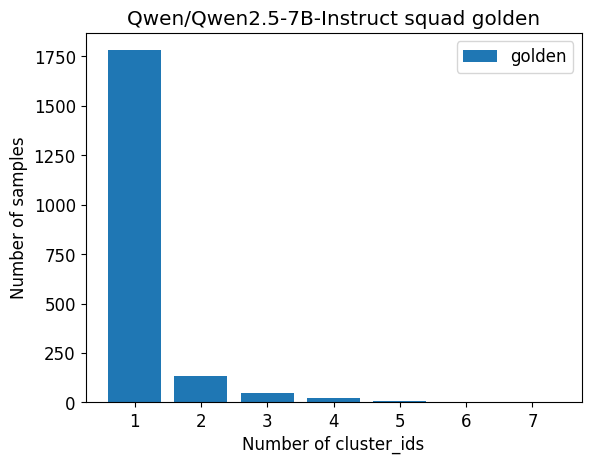

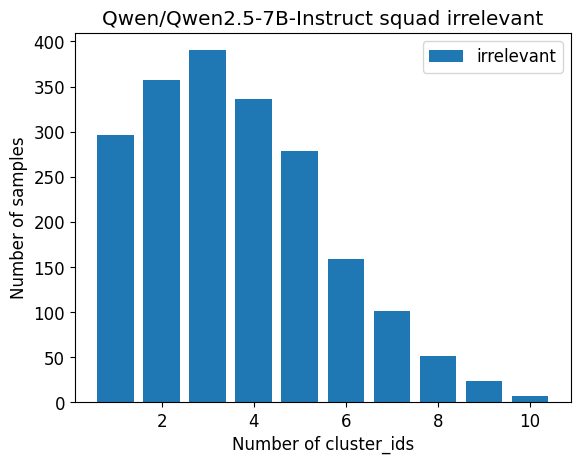

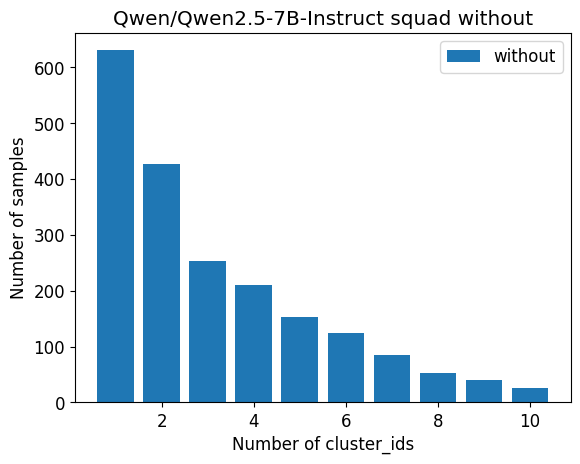

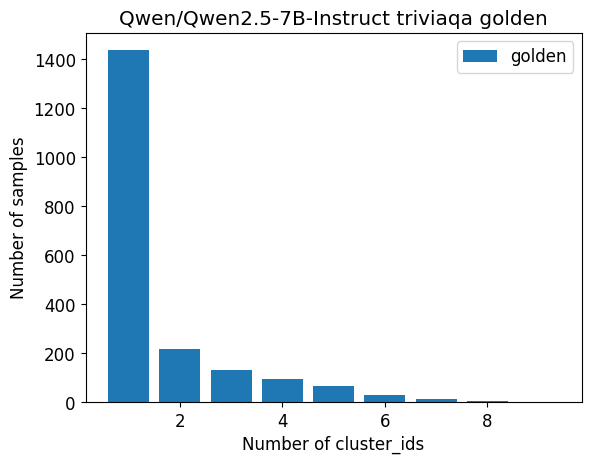

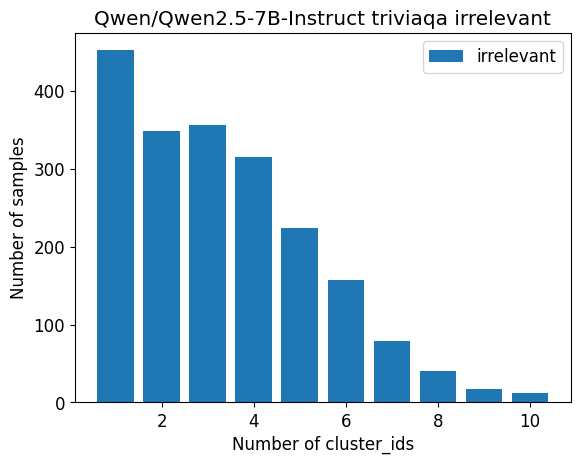

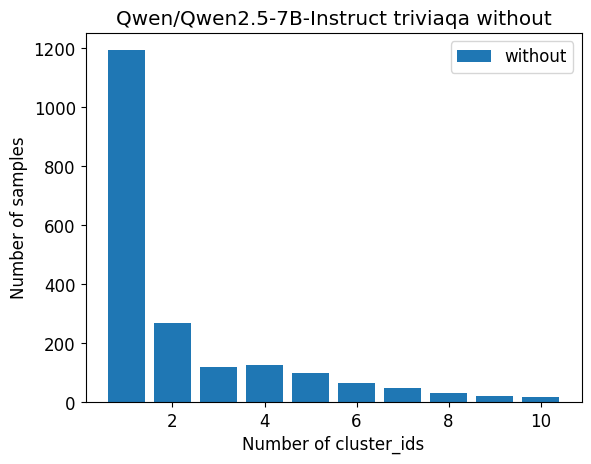

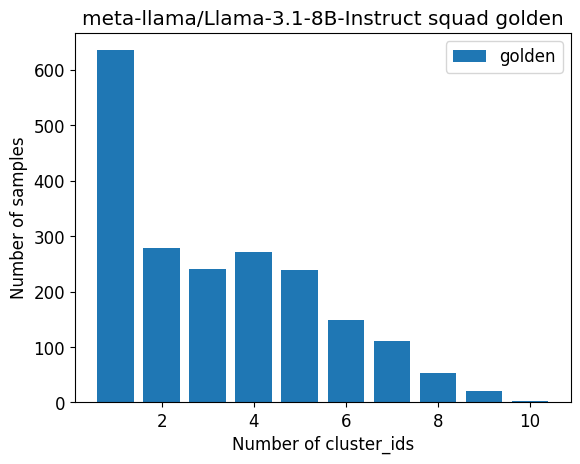

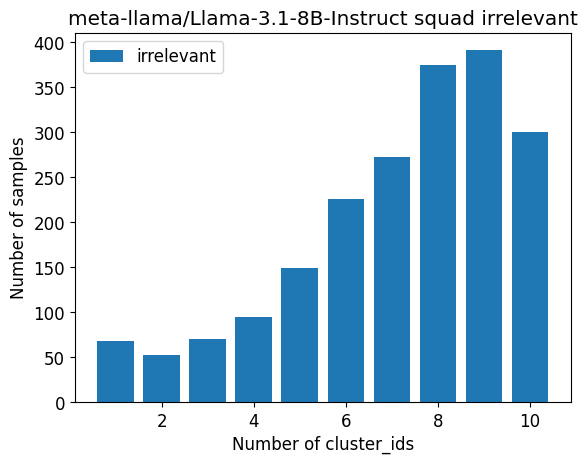

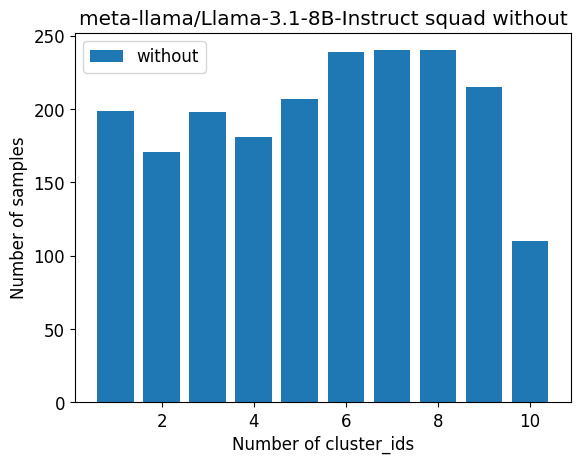

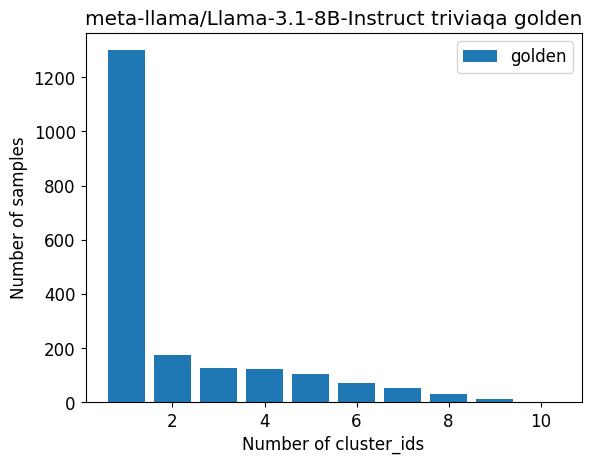

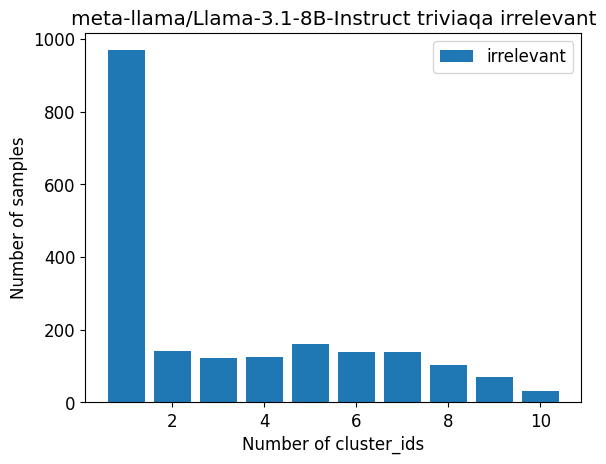

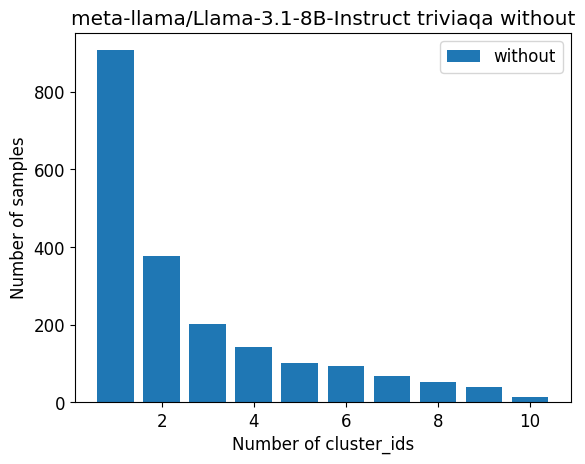

CPU times: user 7.09 s, sys: 6.97 s, total: 14.1 s
Wall time: 14.1 s


In [4]:
# 聚簇数量分布
def stat_cluster_ids(result):
    from collections import Counter
    gen_counts = defaultdict(Counter)
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            cluster_ids = data[sample_type]['cluster_ids']
            # 计算cluster_ids中不同元素的个数（聚簇数量）
            num_cluster_ids = len(set(cluster_ids))
            gen_counts[sample_type].update([num_cluster_ids])
    return gen_counts

def visualize_cluster_ids_distribution(gen_counts, model_name, dataset_name):
    # 可视化分布
    import matplotlib.pyplot as plt
    import seaborn as sns
    for sample_type in ['golden', 'irrelevant', 'without']:
        x, y = zip(*sorted(gen_counts[sample_type].items()))
        plt.bar(x, y, label=sample_type)
        plt.legend()
        plt.xlabel('Number of cluster_ids')
        plt.ylabel('Number of samples')
        plt.title(f'{model_name} {dataset_name} {sample_type}')
        plt.show()

def do_stat_cluster_ids():
    model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
    dataset_names = ["squad", "triviaqa"]
    for model_name in model_names:
        for dataset_name in dataset_names:
            result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_train.pkl")
            gen_counts = stat_cluster_ids(result)
            visualize_cluster_ids_distribution(gen_counts, model_name, dataset_name)

%time do_stat_cluster_ids()

In [5]:
# 统计模型针对数据集的三种不同采样的准确率和语义熵
def stat_accuracy(result):
    accs = {}
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            greedy = data[sample_type]['greedy']
            if greedy is None:
                continue
            acc = greedy['accuracy']
            if sample_type not in accs:
                accs[sample_type] = []
            accs[sample_type].append(acc)
    return accs

def stat_entropy(result):
    entropies = {}
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            d = data[sample_type]
            entropy = d['entropy']
            if sample_type not in entropies:
                entropies[sample_type] = []
            entropies[sample_type].append(entropy)
    return entropies

def do_stat_accuracy():
    model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
    dataset_names = ["squad", "triviaqa"]
    splits = ["train", "validation", "test"]
    for model_name in model_names:
        for dataset_name in dataset_names:
            for split in splits:
                print(f"{model_name} {dataset_name} {split}:")
                result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_{split}.pkl")
                stat_acc = stat_accuracy(result)
                stat_ent = stat_entropy(result)
                for sample_type in ['golden', 'irrelevant', 'without']:
                    print(f"> {sample_type} accuracy: {sum(stat_acc[sample_type]) / len(stat_acc[sample_type]):.3f}")
                    print(f"> {sample_type} entropy: {sum(stat_ent[sample_type]) / len(stat_ent[sample_type]):.3f}")

%time do_stat_accuracy()

Qwen/Qwen2.5-7B-Instruct squad train:
> golden accuracy: 0.876
> golden entropy: 0.085
> irrelevant accuracy: 0.111
> irrelevant entropy: 0.995
> without accuracy: 0.260
> without entropy: 0.766
Qwen/Qwen2.5-7B-Instruct squad validation:
> golden accuracy: 0.880
> golden entropy: 0.105
> irrelevant accuracy: 0.140
> irrelevant entropy: 1.090
> without accuracy: 0.300
> without entropy: 0.734
Qwen/Qwen2.5-7B-Instruct squad test:
> golden accuracy: 0.880
> golden entropy: 0.072
> irrelevant accuracy: 0.210
> irrelevant entropy: 1.037
> without accuracy: 0.340
> without entropy: 0.603
Qwen/Qwen2.5-7B-Instruct triviaqa train:
> golden accuracy: 0.822
> golden entropy: 0.271
> irrelevant accuracy: 0.421
> irrelevant entropy: 0.883
> without accuracy: 0.619
> without entropy: 0.447
Qwen/Qwen2.5-7B-Instruct triviaqa validation:
> golden accuracy: 0.820
> golden entropy: 0.301
> irrelevant accuracy: 0.450
> irrelevant entropy: 0.844
> without accuracy: 0.640
> without entropy: 0.498
Qwen/Qwen2